Analyze merged snm3C-seq data for inhibitory (IN) and excitatory (EN) neurons from middle temporal gyrus obtained from Tian et al., 2023 paper

To make a .mcool files for snm3c-seq data:
1) Download ".3C.contact.tsv.gz" files from Supplementary data of GEO: GSE232495
2) Use Supplementary Tables S4 and S5 from Tian et al., 2023 to select excitatory (EN) and inhibitory (IN) neurons from Middle Temporal Gyrus (MTG)
3) Concatenate selected ".3C.contact.tsv.gz" files into one. Sample EN and IN files to the same number of pairs.
4) Run "cooler cload pairs --assembly hg38 -c1 2 -p1 3 -c2 6 -p2 7 <chrom_sizes_file>:10000 <concatenated.3C.contact.tsv.gz> <output.cool>"
5) Balance and zoomify cooler "cooler zoomify -r 10000N --balance <output.cool>"

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from chromosome_plotting import Chromosome
import numpy as np
import pandas as pd
import seaborn as sns
import bioframe as bf
import bbi
import cooler
import cooltools
from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_enrichment
from pybedtools import BedTool as pbt
import utils
from adjustText import adjust_text


# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

# Input data to run this notebook

In [2]:
# snm3C-seq pairs merged and converted to .mcool 
clr_path = {
    'EN': "../../MTG.EN.2786_cells.10kb.mcool",
    'IN': "../../MTG.IN.2786_cells.mcool"
}
cts = list(clr_path.keys()) # cell types

neuronal_dot_anchor_path = "../data/Suppl. Table S2. Neuronal dot anchors.xlsx"

# These files can be obtained by running fithic.ipynb
fithic_path = {
    'EN': "../data/neuronal_dots.EN.bedpe.gz",
    'IN': "../data/neuronal_dots.IN.bedpe.gz",
}

# Expression data for GABAergic and glutamatergic neurons obtained 
# by reanalyzing the dataset from Kozlenkov et al., 2018: 
# https://doi.org/10.1126/sciadv.aau6190
# Counts are log2(TPM + 1)
koz_cnts_path = '../data/kozlenkov2018.log2TPM_counts.tsv.gz'

# H3K27me3 ChIP-seq profiles for GABAergic and 
# Glutamatergic neurons obtained from Kozlenkov et al., 2018:
# https://doi.org/10.1126/sciadv.aau6190
# ChIP-seq profiles in these files are not whole-genome, they
# are cut to only include loci of 6 genes: 
# DLX5, DLX6, SOX2, GAD2, SLC32A1, ARX.
H3K27me3_path = {
    "Inhibitory neurons": '../data/GABA.merged.6_regs.bigWig',
    "Excitatory neurons": '../data/GLU.merged.6_regs.bigWig',
}

# Plot: average neuronal dot (Figure 5A)

In [3]:
# Load hi-c matrices
res = 10_000
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}

In [4]:
# Load peaks and merge
dot_anch = pd.read_excel(neuronal_dot_anchor_path, na_values='-', skiprows=2)

dot_anch.loc[:, 'mid_start'] = (dot_anch['start'] + dot_anch['end']) / 2 \
    - ((dot_anch['start'] + dot_anch['end']) / 2) % res
dot_anch.loc[:, 'mid_end'] = dot_anch['mid_start'] + res
dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)
dot_anch.head()

/tmp/ipykernel_1894472/3779834246.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
/tmp/ipykernel_1894472/3779834246.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)


,chrom,start,end,genes,mid_start,mid_end
0,chr1,18630000,18640000,PAX7,18630000,18640000
1,chr1,24930000,24940000,RUNX3,24930000,24940000
2,chr1,44410000,44420000,RNF220,44410000,44420000
3,chr1,46480000,46490000,DMBX1,46480000,46490000
4,chr1,47230000,47240000,"TAL1,AL135960.1",47230000,47240000


In [5]:
# CIS expected
cvd_10 = {}

for ct in cts:
    print(ct)
    cvd_10[ct] = cooltools.expected_cis(
        clrs[ct],
        smooth=False,
        nproc=10
    )

EN
IN


In [6]:
# TRANS expected
trans_cvd_10 = {}

for ct in cts:
    print(ct)
    trans_cvd_10[ct] = cooltools.expected_trans(
        clrs[ct],
        nproc=10
    )

EN
IN


In [7]:
# Split by distance
nproc=10
pup_hand = {ct: {} for ct in cts}

for ct in cts:
    print(ct)
    pup_hand[ct]['short'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=cvd_10[ct],
        flank=150000,
        mindist=3*res,
        maxdist=int(3e6),
        nproc=nproc
    );
    pup_hand[ct]['long'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=cvd_10[ct],
        flank=150000,
        mindist=int(3e6),
        nproc=nproc
    );
    pup_hand[ct]['trans'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=trans_cvd_10[ct],
        flank=150000,
        trans=True,
        nproc=nproc
    );

EN


INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr5', 'chr5'): 5
INFO:coolpuppy:('chr10', 'chr10'): 16
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr13', 'chr13'): 2
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr1', 'chr1'): 13
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr12', 'chr12'): 3
INFO:coolpuppy:('chr20', 'chr20'): 1
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chrX', 'chrX'): 2
INFO:coolpuppy:Total number of piled up windows: 91
INFO:coolpuppy:('chr9', 'chr9'): 66
INFO:coolpuppy:('chr10', 'chr10'): 120
INFO:coolpuppy:('chr7', 'chr7'): 58
INFO:coolpuppy:('chr4', 'chr4'): 85
INFO:coolpuppy:('chr8', 'chr8'): 27
INFO:coolpuppy:('chr6', 'chr6'): 98
INFO:

IN


INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr1', 'chr1'): 13
INFO:coolpuppy:('chr10', 'chr10'): 16
INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:('chr12', 'chr12'): 3
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 2
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 1
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr5', 'chr5'): 5
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chrX', 'chrX'): 2
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:Total number of piled up windows: 91
INFO:coolpuppy:('chr9', 'chr9'): 66
INFO:coolpuppy:('chr4', 'chr4'): 85
INFO:coolpuppy:('chr1', 'chr1'): 218
INFO:coolpuppy:('chr7', 'chr7'): 58
INFO:coolpuppy:('chr10', 'chr10'): 120
INFO:coolpuppy:('chr3', 'chr3'): 34
INFO

Text(0.5, 0, 'Distance from\nH3K27me3 peak')

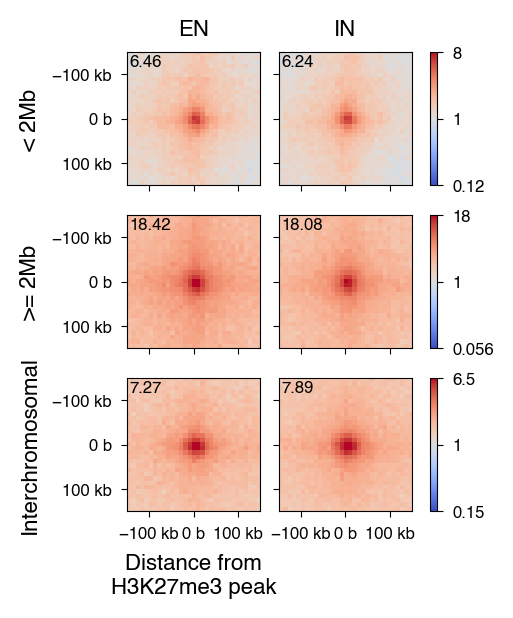

In [8]:
# Plot data for each ct separately
bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1e5))
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1e5))
        ax.xaxis.tick_bottom()
        
        
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols+1, dpi=200, figsize=(2, 3),
                        gridspec_kw={'width_ratios': [1, 1, 0.05]})

vmax = {'short': 8, 'long': 18, 'trans': 6.5}
vmin = {k: 1/val for k, val in vmax.items()}
pup_grps = ['short', 'long', 'trans']

for i, pup in enumerate(pup_grps):
    for j, ct in enumerate(cts):
        arr = pup_hand[ct][pup]['data'][0]
        im = axs[i, j].imshow(
            arr, 
            cmap='coolwarm',
            norm=LogNorm(vmax=vmax[pup], vmin=vmin[pup]),
            extent=(-150000, 150000, 150000, -150000)
        )
        # Enrichment
        en = get_enrichment(arr, 0)
        axs[i, j].text(0.02, 0.98, round(en, 2), va='top', 
                       transform=axs[i, j].transAxes, fontsize=6)
        format_ticks(axs[i, j])
    
    # Colorbar
    plt.colorbar(im, cax=axs[i, ncols], ticks=[vmin[pup], 1, vmax[pup]], 
                 format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
    axs[i, ncols].set_box_aspect(20)
    axs[i, ncols].minorticks_off()

# Ticks
for i in range(3):
    axs[i, 1].yaxis.set_ticklabels([])
for i, j in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    axs[i, j].xaxis.set_ticklabels([])
    
# Labels
axs[0, 0].set_title(cts[0])
axs[0, 1].set_title(cts[1])
axs[0, 0].set_ylabel('< 2Mb')
axs[1, 0].set_ylabel('>= 2Mb')
axs[2, 0].set_ylabel('Interchromosomal')
axs[2, 0].set_xlabel('Distance from\nH3K27me3 peak')

# Plot: Figure 5B

In [9]:
# Read data
res = 50_000 # Hi-C resolution
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}

In [10]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes_view = pd.DataFrame(data={'chrom': hg38_chromsizes.index, 
                                          'start': 0*len(hg38_chromsizes),
                                          'end': hg38_chromsizes.values,
                                          'name': hg38_chromsizes.index})
hg38_chromsizes_view.head()

,chrom,start,end,name
0,chr1,0,248956422,chr1
1,chr2,0,242193529,chr2
2,chr3,0,198295559,chr3
3,chr4,0,190214555,chr4
4,chr5,0,181538259,chr5


In [11]:
# Load peaks and merge
dot_anch = pd.read_excel(neuronal_dot_anchor_path, na_values='-', skiprows=2)
dot_anch = bf.sort_bedframe(dot_anch, hg38_chromsizes_view)

dot_anch.loc[:, 'mid_start'] = (dot_anch['start'] + dot_anch['end']) / 2 \
    - ((dot_anch['start'] + dot_anch['end']) / 2) % res
dot_anch.loc[:, 'mid_end'] = dot_anch['mid_start'] + res
dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)
dot_anch['idx'] = dot_anch.index
dot_anch.head()

/tmp/ipykernel_1894472/2692993644.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
/tmp/ipykernel_1894472/2692993644.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)


,chrom,start,end,genes,mid_start,mid_end,idx
0,chr1,18630000,18640000,PAX7,18600000,18650000,0
1,chr1,24930000,24940000,RUNX3,24900000,24950000,1
2,chr1,44410000,44420000,RNF220,44400000,44450000,2
3,chr1,46480000,46490000,DMBX1,46450000,46500000,3
4,chr1,47230000,47240000,"TAL1,AL135960.1",47200000,47250000,4


In [12]:
pair_sites = bf.pair_by_distance(
    dot_anch, min_sep=10_000, max_sep=int(1e10), suffixes=('1', '2')
)
pair_sites.head()

,chrom1,start1,end1,genes1,mid_start1,mid_end1,idx1,chrom2,start2,end2,genes2,mid_start2,mid_end2,idx2
0,chr18,860000,880000,"ADCYAP1,AP000894.2",850000,900000,196,chr18,3440000,3450000,TGIF1,3400000,3450000,197
1,chr18,860000,880000,"ADCYAP1,AP000894.2",850000,900000,196,chr18,22160000,22170000,"GATA6,GATA6-AS1",22150000,22200000,198
2,chr18,3440000,3450000,TGIF1,3400000,3450000,197,chr18,22160000,22170000,"GATA6,GATA6-AS1",22150000,22200000,198
3,chr18,860000,880000,"ADCYAP1,AP000894.2",850000,900000,196,chr18,47220000,47230000,SKOR2,47200000,47250000,199
4,chr18,3440000,3450000,TGIF1,3400000,3450000,197,chr18,47220000,47230000,SKOR2,47200000,47250000,199


In [13]:
# CIS obs/exp
cvd_100 = {}

for ct in cts:
    print(ct)
    cvd_100[ct] = cooltools.expected_cis(
        clrs[ct],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=10
    )

EN
IN


In [14]:
# Read fithic
fithic = {ct: pd.read_table(fithic_path[ct]) for ct in ['EN', 'IN']}
fithic[ct].head()

,chrom1,start1,end1,chrom2,start2,end2,q-value
0,chr1,18600000,18700000,chr1,24900000,25000000,2.999725e-65
1,chr1,18600000,18700000,chr1,44400000,44500000,1.429488e-71
2,chr1,24900000,25000000,chr1,44400000,44500000,6.551893e-31
3,chr1,18600000,18700000,chr1,46400000,46500000,8.242234e-05
4,chr1,24900000,25000000,chr1,46400000,46500000,1.359259e-05


In [15]:
# Make interactions out of polycomb anchors
# Convert peak coordinates to corresponding hic bins
hand_df_bins = utils.regs_to_bins(dot_anch, 100_000, mode='all')\
    .drop_duplicates(['chrom', 'start', 'end'])\
    .drop(columns=['mid_start', 'mid_end']) # for fithic
hand_df_bins_50 = utils.regs_to_bins(dot_anch, 50_000, mode='middle')\
    .drop_duplicates(['chrom', 'start', 'end'])\
    .drop(columns=['mid_start', 'mid_end']) # for pileup

# Merge bins from two resolutions
hand_df_bins = hand_df_bins\
    .merge(hand_df_bins_50[['start', 'end', 'idx']], on='idx', suffixes=['', '_mid'])\
    .drop(columns='idx')
hand_df_bins['idx_bin'] = hand_df_bins.index

# Assign UCSC region title to anchors without genes
hand_df_bins['ucsc'] = hand_df_bins['chrom'] + ':' + hand_df_bins['start'].astype(str) + '-' + \
        hand_df_bins['end'].astype(str)
hand_df_bins['genes'].fillna(hand_df_bins['ucsc'], inplace=True)
hand_df_bins.drop(columns='ucsc', inplace=True)

pair_sites = bf.pair_by_distance(hand_df_bins, min_sep=200_000, 
                                 max_sep=int(1e10), suffixes=('1', '2'))

pair_sites = pair_sites.merge(fithic['EN'], how='left', suffixes=['', '_EN'],
                              on=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
pair_sites = pair_sites.merge(fithic['IN'], how='left', suffixes=['', '_IN'], 
                              on=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
pair_sites = pair_sites.rename(columns={'q-value': 'q-value_EN'})
pair_sites[['dot_EN', 'dot_IN']] = \
    pair_sites[['q-value_EN', 'q-value_IN']].fillna(0).astype(bool)

pair_sites.head()

/tank/projects/schizophrenia_2021/results/2024.01.10/NeuN_plus_minus_paper/code/utils.py:192: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bins_df.loc[:, 'start'] = (bins_df['start'] + bins_df['end']) / 2 \
/tank/projects/schizophrenia_2021/results/2024.01.10/NeuN_plus_minus_paper/code/utils.py:194: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bins_df.loc[:, 'end'] = bins_df['start'] + binsize
/tank/projects/schizophrenia_2021/results/2024.01.10/NeuN_plus_minus_paper/code/utils.py:195: FutureWarning: In a future version, `df.iloc[:, i] = newvals` w

,chrom1,start1,end1,genes1,start_mid1,end_mid1,idx_bin1,chrom2,start2,end2,genes2,start_mid2,end_mid2,idx_bin2,q-value_EN,q-value_IN,dot_EN,dot_IN
0,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,3400000,3500000,TGIF1,3400000,3450000,211,3.089067e-13,8.423981e-25,True,True
1,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,22100000,22200000,"GATA6,GATA6-AS1",22150000,22200000,212,5.472458e-14,2.430111e-24,True,True
2,chr18,3400000,3500000,TGIF1,3400000,3450000,211,chr18,22100000,22200000,"GATA6,GATA6-AS1",22150000,22200000,212,3.685447e-46,7.279323e-51,True,True
3,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,47200000,47300000,SKOR2,47200000,47250000,213,NaN,4.201362e-12,False,True
4,chr18,3400000,3500000,TGIF1,3400000,3450000,211,chr18,47200000,47300000,SKOR2,47200000,47250000,213,1.891891e-16,2.458289e-40,True,True


In [16]:
# Create pileups
stack = {}
flank = 10*res
stack_ps = pair_sites\
    .drop(columns=['start1', 'end1', 'start2', 'end2'])\
    .rename(
        columns={'start_mid1': 'start1', 'end_mid1': 'end1',
                 'start_mid2': 'start2', 'end_mid2': 'end2'}
    )
for ct in cts:
    print(ct)
    stack[ct] = cooltools.pileup(
        clrs[ct], 
        stack_ps, 
        view_df=hg38_chromsizes_view, 
        expected_df=cvd_100[ct], 
        flank=flank
    )

EN
IN


In [17]:
# Add pileup values to a pair table
for ct in cts:
    pair_sites[f'vals_{ct}'] = stack[ct].tolist()
    
pair_sites.head()

,chrom1,start1,end1,genes1,start_mid1,end_mid1,idx_bin1,chrom2,start2,end2,genes2,start_mid2,end_mid2,idx_bin2,q-value_EN,q-value_IN,dot_EN,dot_IN,vals_EN,vals_IN
0,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,3400000,3500000,TGIF1,3400000,3450000,211,3.089067e-13,8.423981e-25,True,True,"[[2.2289719962118446, 1.59164903204025, 1.4808...","[[0.9238670213899337, 0.7733056882725355, 0.84..."
1,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,22100000,22200000,"GATA6,GATA6-AS1",22150000,22200000,212,5.472458e-14,2.430111e-24,True,True,"[[2.07366050074862, 1.4748986141941185, 1.8489...","[[1.200637310243204, 3.0119226945608384, 3.330..."
2,chr18,3400000,3500000,TGIF1,3400000,3450000,211,chr18,22100000,22200000,"GATA6,GATA6-AS1",22150000,22200000,212,3.685447e-46,7.279323e-51,True,True,"[[2.086774503810445, 2.1156221851734838, 2.558...","[[1.7233169940355042, 0.6211111124655003, 1.23..."
3,chr18,800000,900000,"ADCYAP1,AP000894.2",850000,900000,210,chr18,47200000,47300000,SKOR2,47200000,47250000,213,NaN,4.201362e-12,False,True,"[[0.0, 0.4384201765611235, 1.4545067485957772,...","[[0.6752795842109557, 1.4927034401083874, 0.76..."
4,chr18,3400000,3500000,TGIF1,3400000,3450000,211,chr18,47200000,47300000,SKOR2,47200000,47250000,213,1.891891e-16,2.458289e-40,True,True,"[[1.8210897901659397, 0.0, 2.4587970939656896,...","[[0.39029016920425863, 1.4465996253242959, 0.4..."


In [18]:
# For each interaction "locus1-locus2" add symmetrical
# interaction "locus2-locus1"
stat_df = pd.concat([
        pair_sites[['idx_bin1', 'idx_bin2', 'vals_EN', 'vals_IN', 'dot_EN', 'dot_IN']],
        pair_sites[['idx_bin1', 'idx_bin2', 'vals_EN', 'vals_IN', 'dot_EN', 'dot_IN']]\
            .rename(columns={'idx_bin1': 'idx_bin2', 'idx_bin2': 'idx_bin1'})
    ], ignore_index=True)\
    .sort_values(['idx_bin1', 'idx_bin2'])

stat_df.head()

,idx_bin1,idx_bin2,vals_EN,vals_IN,dot_EN,dot_IN
260,0,1,"[[1.2017289051153077, 1.8686168435844, 1.23476...","[[0.7407893638550501, 2.0744620211572724, 1.33...",True,True
261,0,2,"[[0.3503245134709698, 0.33698630162681553, 1.9...","[[0.9154918591430254, 2.0653685707322276, 1.40...",True,True
263,0,3,"[[0.7405011028906854, 0.7158906410952293, 0.81...","[[1.353715115919488, 0.657766615980451, 2.9032...",True,True
266,0,4,"[[0.3880562480027104, 2.274229209682139, 1.556...","[[1.057502482364395, 0.0, 1.0766425754364946, ...",True,True
270,0,5,"[[2.1403663356447042, 1.1761433864498674, 0.0,...","[[1.1225328688399574, 1.0196933820758682, 0.36...",True,True


In [19]:
# Get type-specific anchors
stat_gb = stat_df\
    .loc[(stat_df['dot_EN'] == True) & (stat_df['dot_IN'] == False)]\
    .groupby('idx_bin1')\
    .agg({
        'idx_bin2': 'unique', 'vals_EN': list, 'vals_IN': list, 'dot_EN': sum, 'dot_IN': sum
    })\
    .join(hand_df_bins['genes'].str.split(',').str[0])

EN_only_dot = stat_gb\
    .loc[stat_gb['genes'].isin(['DLX5', 'SOX2', 'GAD2', 'SLC32A1', 'ARX'])]\
    .reset_index(drop=True)
EN_only_dot

,idx_bin2,vals_EN,vals_IN,dot_EN,dot_IN,genes
0,"[41, 42, 43, 44, 45, 46, 47, 48]","[[[0.0, 0.0, 0.0, 2.955964635048853, 1.8025378...","[[[0.0, 0.0, 1.9201502964734938, 0.98025704441...",8,0,SOX2
1,"[97, 98, 99, 100, 101, 102, 103, 104, 105, 106...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.6251125085295774...","[[[1.0645691362602512, 0.0, 0.0, 2.31152086522...",14,0,DLX5
2,"[137, 138, 139, 145, 151, 153, 154]","[[[1.8535690044893047, 2.2856557533615676, 1.2...","[[[0.3371422310589362, 0.36155129679835113, 0....",7,0,GAD2
3,"[215, 216, 217]","[[[0.0, 0.5840685501681584, 0.0, 0.84109885577...","[[[0.6691456533469593, 0.3362039842296763, 0.3...",3,0,SLC32A1
4,"[227, 228]","[[[0.0, 0.0, 2.530561438289898, 0.0, 0.0, 1.25...","[[[1.4780887083104348, 0.0, 0.0, 0.0, 0.0, 1.5...",2,0,ARX


In [20]:
# hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')\
    .set_index('chrom')\
    .rename(columns={'mid': 'cent'})\
    .loc[:, 'cent']
hg38_cens.head()

chrom
chr1    123400000
chr2     93900000
chr3     90900000
chr4     50000000
chr5     48800000
Name: cent, dtype: int64

In [21]:
# Read gene count data to get gene chromosome
koz_cnts = pd.read_table(koz_cnts_path)

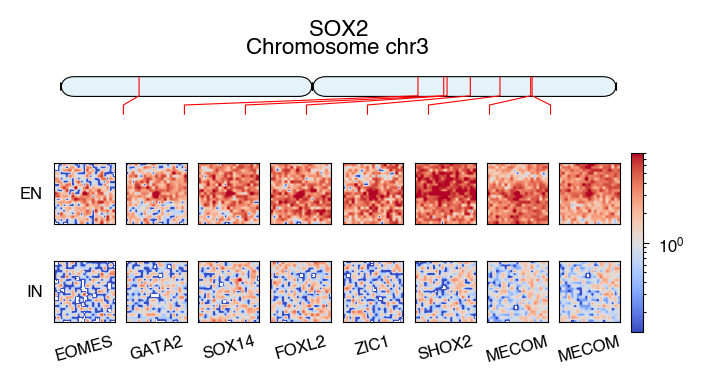

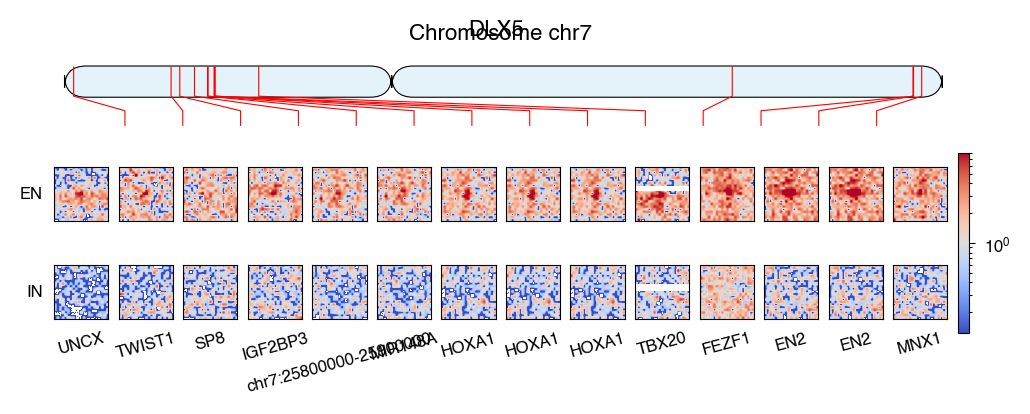

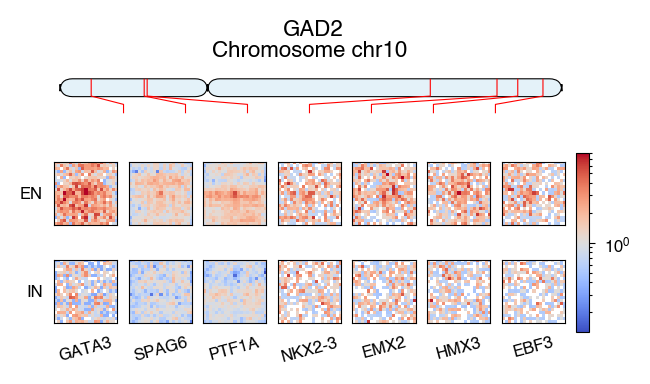

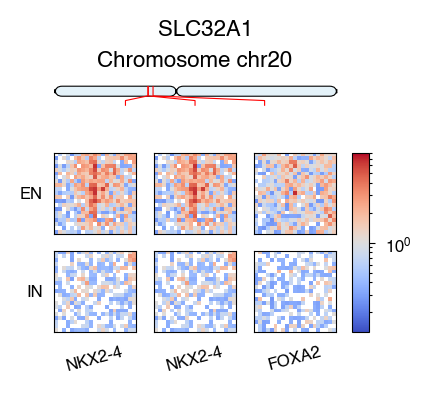

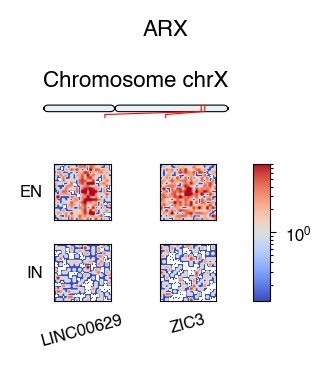

In [22]:
for idx, row in EN_only_dot.iterrows():
    ndots = row['dot_EN']
    target_genes = hand_df_bins.loc[row['idx_bin2'], 'genes'].str.split(',').str[0].values
    
    wr = [1] * ndots
    wr.append(0.2)
    fig, axs = plt.subplots(3, ndots+1, dpi=200, figsize=[1 + 0.35*ndots, 1.8],
                            gridspec_kw={'width_ratios': wr})
    for ax in axs[:, ndots]:
        ax.remove()
    plt.suptitle(row['genes'], fontsize=8)
    
    # Plot chromosome
    for ax in axs[0, :ndots]:
        ax.remove()
    gs = axs[0, 0].get_gridspec()
    ax_chr = fig.add_subplot(gs[0, :-1])
    chrom = koz_cnts.set_index('gene.name').loc[row['genes'], 'chrom']
    loci = hand_df_bins.loc[row['idx_bin2'], 'start'].sort_values()
    chrom_plot = Chromosome(length=hg38_chromsizes[chrom], 
                            name=chrom, 
                            centromere=hg38_cens[chrom],
                            loci=loci)
    chrom_plot.plot_chromosome(ax=ax_chr, height=3, linewidth=0.4)
    
    # Plot snips
    for i, ct in enumerate(['EN', 'IN'], start=1):
        arr = np.array(row[f'vals_{ct}'])
        
        if ct == 'EN': # determine maximum value for colorbar
            peak = np.max(arr[:, arr.shape[1] // 2, arr.shape[2] // 2]) * 0.45
        
        axs[i, 0].set_ylabel(ct, rotation='horizontal', fontsize=6, ha='right', va='center')
            
        for j in range(ndots):
            ax = axs[i, j]
            pup = ax.imshow(
                arr[j, :, :], 
                cmap='coolwarm',
                norm=LogNorm(vmax=8, vmin=1/8)
            )
            ax.set_aspect(1)
            ax.set_xticks([])
            ax.set_yticks([])
            
            if i == 2:
                ax.set_xlabel(target_genes[j], rotation=15, fontsize=6)
    
    ax_cb = fig.add_subplot(gs[1:, ndots])          
    fig.colorbar(pup, cax=ax_cb, shrink=0.25)

plt.tight_layout()

# H3K27me3 in ct-specific anchors (Figure 5D)

In [23]:
# Save chromosome sizes to a file fo pybedtools
chrom_path = '../data/hg38.chrom_sizes.bed'
hg38_chromsizes.to_csv(chrom_path, header=False, index=True, sep='\t')

In [25]:
# List of genes
dif_dot_gene = ['DLX5', 'DLX6', 'SOX2', 'GAD2', 'SLC32A1', 'ARX']

# Get dot positions
dif_dot_riz = koz_cnts.loc[koz_cnts['gene.name'].isin(dif_dot_gene)]\

# Get gene tss
bed_cols = ['chrom', 'start', 'end', 'gene.name', 'gene.id', 'strand']
dif_dot_tss = pbt.from_dataframe(dif_dot_riz[bed_cols])\
    .flank(g=chrom_path, s=True, l=1, r=0)\
    .to_dataframe(names=bed_cols)\
    .set_index('gene.name')\
    .loc[dif_dot_gene]
dif_dot_tss.head(6)

,chrom,start,end,gene.id,strand
gene.name,,,,,
DLX5,chr7,97024950,97024951,ENSG00000105880,-
DLX6,chr7,97005551,97005552,ENSG00000006377,+
SOX2,chr3,181711923,181711924,ENSG00000181449,+
GAD2,chr10,26216663,26216664,ENSG00000136750,+
SLC32A1,chr20,38724484,38724485,ENSG00000101438,+
ARX,chrX,25016420,25016421,ENSG00000004848,-


Text(0.5, 0.98, 'H3K27me3 signal')

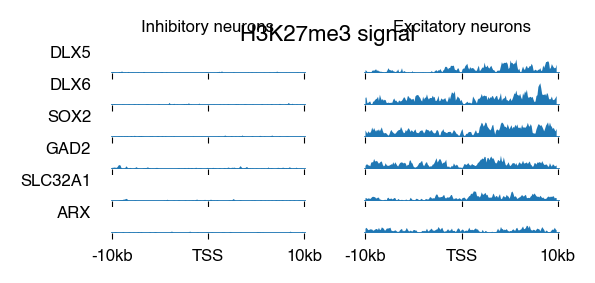

In [27]:
offset, nbins = 10_000, 200
plot_df = dif_dot_tss.copy(deep=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset

fig, axs = plt.subplots(plot_df.shape[0], 2, dpi=200, 
                        figsize=[3, 0.2 * plot_df.shape[0]], 
                        sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.25)

for j, (name, path) in enumerate(H3K27me3_path.items()):
    
    s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
    s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
    
    for i, gene in enumerate(plot_df.index):
        ax = axs[i, j] 
        ax.plot([0, nbins], [0, 0], linewidth=1)
        ax.fill_between(np.arange(nbins), [0]*nbins, s[i, :])
        ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
        ax.set_ylim([0, 0.75])
        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'TSS', f"{offset//1000}kb"])
        ax.set_yticks([])
        
        if j == 0:
            ax.set_ylabel(gene, rotation='horizontal', ha='right', fontsize=6)
        if i == 0:
            ax.set_title(name, fontsize=6)
    
plt.suptitle('H3K27me3 signal', fontsize=8)  

# Plot: expression of 6 genes (Figure 5C)

In [28]:
koz_cnts = pd.read_table(koz_cnts_path)
koz_cnts.head()

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_GLU,log2TPM_SOX,log2TPM_OLIG
0,chrX,100627107,100639991,TSPAN6,-,ENSG00000000003,protein_coding,1.358388,1.575157,2.075568
1,chrX,100584935,100599885,TNMD,+,ENSG00000000005,protein_coding,0.195109,0.076332,0.228532
2,chr20,50934866,50959140,DPM1,-,ENSG00000000419,protein_coding,5.021609,4.870370,4.823697
3,chr1,169849630,169894267,SCYL3,-,ENSG00000000457,protein_coding,3.529446,3.306718,3.420497
4,chr1,169662006,169854080,C1orf112,+,ENSG00000000460,protein_coding,0.724213,0.829007,1.482341


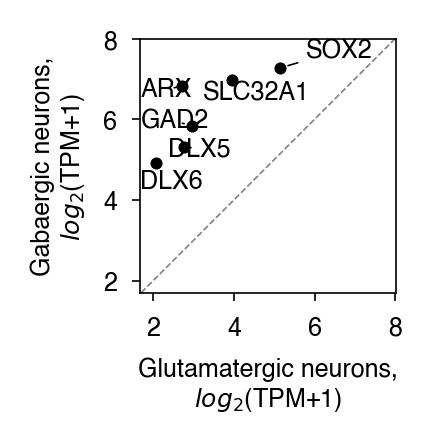

In [29]:
goi = ['DLX5', 'DLX6', 'SOX2', 'ARX', 'GAD2', 'SLC32A1']
plot_df = koz_cnts.set_index('gene.name').loc[goi, ['log2TPM_GLU', 'log2TPM_SOX']]

plt.figure(figsize=[1.1, 1.1], dpi=300)
sns.scatterplot(data=plot_df, x='log2TPM_GLU', y='log2TPM_SOX', c='k', s=10)
plt.plot([1.7, 8], [1.7, 8], '--', c='grey')
plt.axis('equal')
plt.xlim([1.7, 8])
plt.ylim([1.7, 8])
plt.xlabel('Glutamatergic neurons,\n' + r'$log_{2}$(TPM+1)', fontsize=6)
plt.ylabel('Gabaergic neurons,\n' + r'$log_{2}$(TPM+1)', fontsize=6)
plt.xticks([2, 4, 6, 8])

texts = [plt.text(plot_df.loc[goi, 'log2TPM_GLU'].values[i], 
                  plot_df.loc[goi, 'log2TPM_SOX'].values[i], goi[i], fontsize=6) 
         for i in range(len(goi))]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.4))